## Kaytoo | Model Evaluation & Validating Inference
### Bird Call Classification for New Zealand 
This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into the inference `.py` script for deployment.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [1]:
notebook_use = {
                'project_root': 'G:/Kaytoo', #'/media/olly/T7/Kaytoo', # 'G:/Kaytoo',  #'/media/olly/T7/Kaytoo'  
                'experiment': 8,
                'bird_name_csv': 'Data/Experiments/Exp_8/Results/exp_8_bird_map.csv',
                'folder_to_process': 'Data/Soundscapes/DOC_Tier1_2011/',
                'model_choices': [0],
                'cpu_only': False,
                'num_cores': 1  #Can crank this up if using CPU only.
                }

## Imports

In [2]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from IPython.display import Image, display
import re

#External classes and functions
from bird_naming_utils import BirdNamer
from bird_infer_models import Models, ImageDataset, get_images

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Machine Learning 
#import albumentations as A
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

#Torch and PyTorch specific
#import timm
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import pytorch_lightning as pl
from torch.utils.data import  DataLoader
#from torchaudio.functional import compute_deltas

#Audio
import librosa
#import torchaudio
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [3]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu_only']:
                self.device = torch.device('cpu')
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list

In [4]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [5]:
class ModelParameters:
   def __init__(self, options=None):
        self.parameters = [
        {'basename':'tf_efficientnet_b0.ns_jft_in1k',  #Exp_116 LB66, 43 minutes, uses Googlebirds_25 for 7 epochs
                         'ckpt_path': f"{options['project_root']}/Data/Experiments/Exp_8/Results/epoch=5-step=35616.ckpt",
                         'image_shape': (1,2), #The layout of 5-sec spectrograms stacked into the final image (height x width)
                         'image_time': 10,
                         'n_mels': 256,
                         'n_fft': 2048,
                         'use_deltas' : True,
                         'hop_length': 1243,
                         '5_sec_width': 128,
                         'aggregation': 'mean',
                         }, 
        ]
        if options and options.get('model_choice'):
            model_choices = options['model_choice']
            _parameters_list = [_parameters_list[i] for i in model_choices] 

In [6]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.predictions_csv = self.soundscapes_folder / 'predictions.csv'
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'

## Helper Functions

In [7]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

In [8]:
def show_batch(img_ds, model_args, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, _ = img_ds[index]  #returns an image of n chunks
        shape=img.shape
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, 
                                       x_axis='time', 
                                       y_axis='mel', 
                                       sr=32000, 
                                       n_fft=model_args['n_fft'] * model_args['image_shape'][0],
                                       hop_length=model_args['hop_length'],
                                       ax=ax)
        ax.set(title=f'Loading Index {index}, shape: {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")

## Inference Functions

In [9]:
def prediction_for_clip(audio_path,
                        model,
                        sub_process=False):
    model_args=model.parameters
    audio_params=model.audio
    device = model.device 
    
    image_dict, num_extras = get_images(audio_path, model_args, audio_params)
    num_images = len(image_dict)
    dataset = ImageDataset(image_dict, model_args['image_shape'], model_args['use_deltas'])
    shape = model_args['image_shape']
    num_chunks = shape[0] * shape[1]
    batch_size = num_images // num_chunks  #should be a whole number, because we made sure of this in the get_images
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    if not sub_process:
        progress = tqdm(range(len(loader)), desc="Inferring a single soundscape")
    
    for images, _ in loader:
        images=images.to(device)

        with torch.no_grad():
            predictions = model(images)  
            batch_segment_preds = predictions.detach().cpu().numpy()  #batch_size x num_chunks x num_classes
      
        if not sub_process:
            progress.update(1)

    del loader, dataset, image_dict
    if device == torch.device('cuda'):
        torch.cuda.empty_cache()

    #Now let's lop off the last num_extras predictions, as these were made on place-holding random noise
    if num_extras:
        batch_segment_preds = batch_segment_preds[:-num_extras, :]

    return batch_segment_preds


def process_clip(audio_path, model):
    clip_preds = []
    final_row_ids = []
    batch_preds = prediction_for_clip(audio_path,
                                      model,
                                      sub_process=True)
    
    num_preds = batch_preds.shape[0]
    
    for idx in range(num_preds):
        row = batch_preds[idx]
        clip_preds.append(row)
    
    row_ids = [audio_path.stem + f'_{end}' for end in range(5, (num_preds+1)*5, 5)]
    final_row_ids.extend(row_ids)

    return clip_preds, final_row_ids


def inference(test_audios, models, model_idx, cores=1):
    bird_list = models.ebirds
    model = models.get_model(model_idx)
    results = Parallel(n_jobs=cores)(
        delayed(process_clip)(audio_path, model=model) for audio_path in tqdm(test_audios, desc="Overall File List")
        )
    
    del model
    if models.device == torch.device('cuda'):
        torch.cuda.empty_cache()

    clip_preds = [result[0] for result in results]      #This should be a list of 1 x num_classes arrays, with a length = the number of predictions
    final_row_ids = [result[1] for result in results]   #This should be a list of row id's?

    clip_preds = [item for sublist in clip_preds for item in sublist]
    final_row_ids = [item for sublist in final_row_ids for item in sublist]
    prediction_df = pd.DataFrame(clip_preds, columns=bird_list)
    prediction_df.insert(0, 'row_id', final_row_ids)
    
    return prediction_df

## Initialise

In [10]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)
parameters = ModelParameters(options=notebook_use)
models = Models(config=cfg, 
                model_parameters=parameters, 
                audio_parameters=audio)

print('The inference folder is:', paths.soundscapes_folder)
print(f'There are {len(models.args_list)} model(s) to be ensembled')
print(f'The model(s) will predict the following {len(models.ebirds)} birds (referring to their https://ebird.org code): \n')
for i in range(0, len(models.ebirds), 10):
    print(", ".join(models.ebirds[i:i + 10]))

The inference folder is: G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011
There are 1 model(s) to be ensembled
The model(s) will predict the following 87 birds (referring to their https://ebird.org code): 

ausbit1, ausmag2, auspip3, aussho1, baicra4, blbgul1, blfter1, blkswa, bluduc1, calqua
cangoo, caster1, charob1, chiger2, chukar, codpet1, comcha, commyn, compea, comred
coopet, dobplo1, dunnoc1, easros1, eurbla, eurgol, eurgre1, eursta, fernbi1, gretea1
grskiw1, gryger1, houspa, kea1, kelgul, kokako3, larus, liskiw1, litowl1, litpen1
lotkoe1, mallar3, maslap1, morepo2, motpet, nezbel1, nezfal1, nezfan1, nezkak1, nezpig2
nezrob2, nezrob3, nibkiw1, okbkiw1, oyster1, parake, parpet1, parshe1, piesti1, pipipi1
purswa6, rebgul1, redjun1, riflem1, rinphe1, sackin1, saddle2, shbcuc1, silver3, skylar
sobkiw2, soiwre1, sonthr1, spocra1, spocra2, swahar1, takahe3, tomtit1, tui1, weka1
welswa1, weta, whfter1, whiteh1, x00458, yellow2, yellow3


In [11]:
print('\nThe parameters for the first model are:')
for parameter, value in models.args_list[0].items():
    print(f'{parameter}: {value}')


The parameters for the first model are:
basename: tf_efficientnet_b0.ns_jft_in1k
ckpt_path: G:/Kaytoo/Data/Experiments/Exp_8/Results/epoch=5-step=35616.ckpt
image_shape: (1, 2)
image_time: 10
n_mels: 256
n_fft: 2048
use_deltas: True
hop_length: 1243
5_sec_width: 128
aggregation: mean


## Varify the dataset on a Single Soundscape

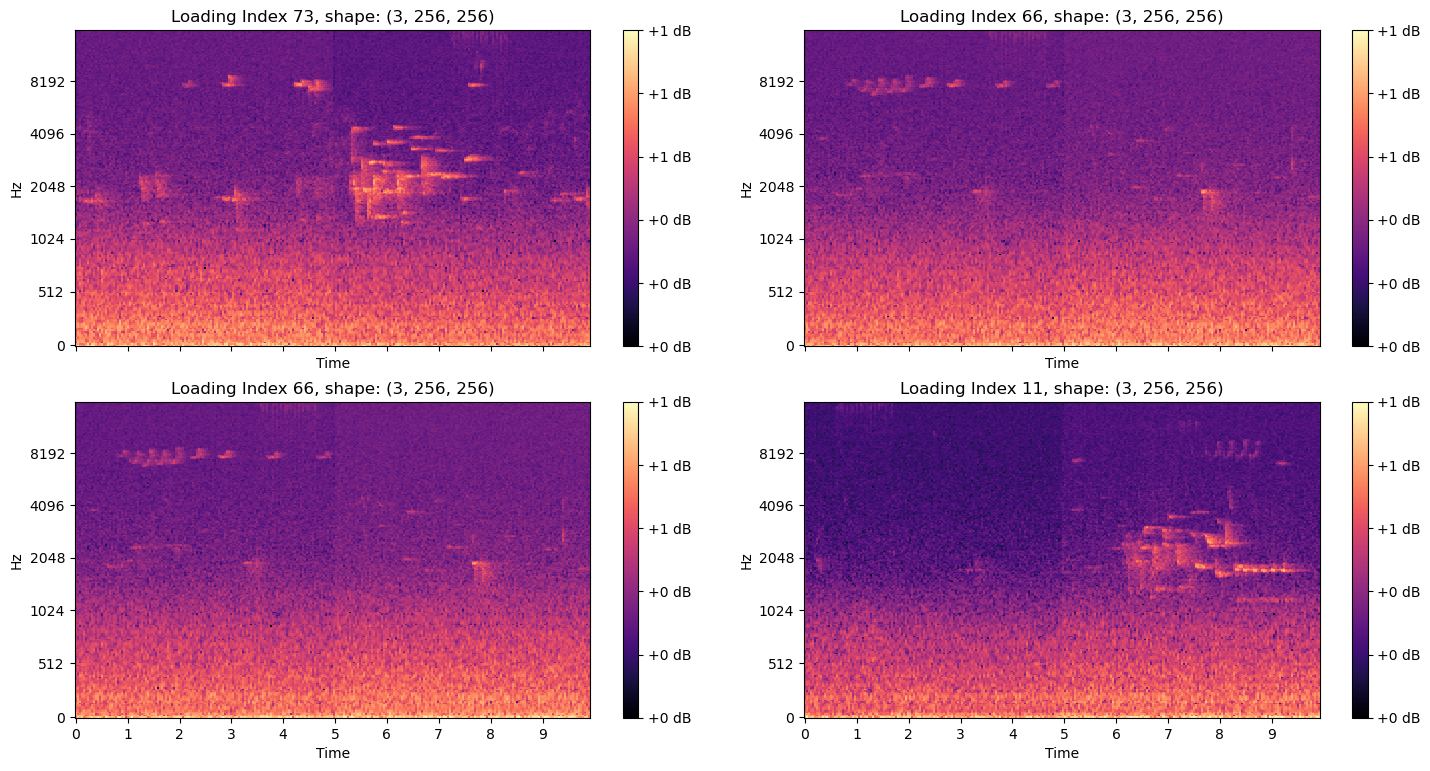

In [12]:
soundscape = random.choice(paths.soundscapes)
image_dict, num_extras = get_images(soundscape, models.args_list[0], audio_params=models.audio)
image_shape = models.args_list[0]['image_shape']
use_deltas = models.args_list[0]['use_deltas']
dataset = ImageDataset(image_dict, image_shape, use_deltas)
show_batch(dataset, models.args_list[0], 2,2)

## Analysis of Training Metrics

### Class Sizes and Distributions

First lets look at the classes and their sizes.

In [13]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(45)

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
0,Spotless Crake,spocra2,Zapornia tabuensis,Crake,10,0.0
1,Eastern Rosella,easros1,Platycercus eximius,Rosella,10,1.0
2,Spotted Crake,spocra1,Porzana porzana,Crake,10,0.0
3,Domestic Chicken,redjun1,Gallus gallus,Chicken,10,0.0
4,Takahe,takahe3,Porphyrio hochstetteri,Takahe,10,0.0
5,Common Diving-Petrel,codpet1,Pelecanoides urinatrix,Petrel,10,0.0
6,Chukor,chukar,Alectoris chukar,Chukor,10,0.0
7,Caspian Tern,caster1,Hydroprogne caspia,Tern,10,0.0
8,Black Petrel,parpet1,Procellaria parkinsoni,Petrel,10,0.0
9,Chatham Robin,charob1,Petroica traversi,Robin,10,0.0


In [14]:
bird_map_df.tail(46)

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
41,Little Spotted Kiwi,liskiw1,Apteryx owenii,Spotted Kiwi,91,10.0
42,Indian Myna,commyn,Acridotheres tristis,Myna,96,11.0
43,Southern Black-backed Gull,kelgul,Larus dominicanus,Gull,114,13.0
44,Red-billed Gull,rebgul1,Chroicocephalus novaehollandiae scopulinus,Gull,115,12.0
45,Starling,eursta,Sturnus vulgaris,Starling,126,14.0
46,Kereru,nezpig2,Hemiphaga novaeseelandiae,Kereru,142,16.0
47,Oystercatcher,oyster1,Haematopus sp,Oystercatcher,152,17.0
48,Paradise Shelduck,parshe1,Tadorna variegata,Shelduck,170,18.0
49,Canada Goose,cangoo,Branta canadensis,Goose,204,22.0
50,New Zealand Falcon,nezfal1,Falco novaeseelandiae,Falcon,211,23.0


A couple of things become obvious:

- This is a highly imbalanced dataset.   More than half the classes have too few samples for any validation metric to have dependable claims as to performance on real world.  Especially when we consider that for each of these classes, there are even fewer sample collection locations, so there will likely be some correlation between the training and validation samples.  

- It makes no sense to split up Variable/South Island Pied Oystercatcher or Yellow/Red/Orange Parakeet, since we have relatively few samples of these species.  Also the diferentiated classes (red/orange/yellow Parakeet) conflict with the samples we have for the more general class (Parakeet). Let's check these have been successfully merged to *oyster1* and *parake*

In [15]:
bird_map_df[bird_map_df['eBird'].isin(['parake', 'yefpar3', 'refpar4', 'oyster1', 'soioys1', 'varoys1'])]

,CommonName,eBird,ScientificName,ExtraName,TrainSamples,ValSamples
47,Oystercatcher,oyster1,Haematopus sp,Oystercatcher,152,17.0
71,Parakeet,parake,Psittaciformes sp.,Parakeet,2579,286.0


### Training Monitors

A custom learning rate scheduler was made for training, with a warmup period, decaying cycles and warm restarts (Only evident if training proceeded to more than one cycle).

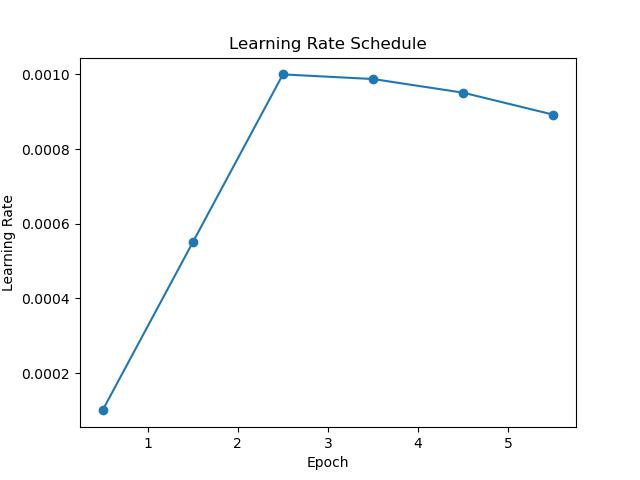

In [16]:
display(Image(filename=paths.train_metric_monitor))

Various performance parameters were monitored during training, on both the training samples and validation. Note that the relatively low scores for training is due to the heavy use of augmentation, and regularisation methods.  The validation samples by contrast were pre-processed in exactly the same way they would be prepared for inference.  Training began with heavy agumentation, and as it progressed the frequency and magnitude of the augmentation effects were reduced.

Plotted metrics:
- Train/Val Loss |  Focal Loss using binary cross entropy
- cmap5 | macro Average Precision score, but with all classes buffered by 5 true positives, to prevent excessive noise from the rare classes.
- LRAP  | Label Ranced Average Precision Score

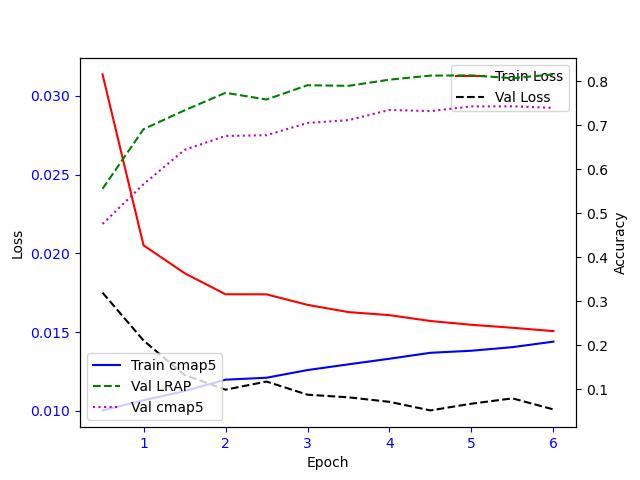

In [17]:
display(Image(filename=paths.learning_rate_monitor))

## Performance on the validation split
- The validation split consists of a random selection of 10% of the audio samples per class, but only for samples where the class had more than 10 samples, otherwise no samples were taken.
- For more than half the classes we don't have much data yet.  What data we have comes mostly from a small number of sites and is thus correlated between samples. For those two reasons there isn't much point trying to make a more sophisticated scheme to accurately predict real-life performance.
- For now I'm just going to make do by looking at the validation set, mainly for classes with more than 50 samples total (so > 5 samples in the validation split).  
- Further development work on training routines will be benchmarked on completely different datasets from Kenya and India, as these area available on Kaggle.  That will reduce the danger of fitting of the training algorithms to this dataset in it's current form.
- At the same time development work ought to be performed on the dataset to improve the size, balance and accuracy of the labels.
- As more data comes to hand from the rarer classes it will become meaningful to develop a rigorous test method.
- From DOC's perspective there is a need to end up with some kind of hidden dataset, with no correllation to the training data.  Either by reserving some of this data by location, or ideally sourcing additional data, targeting the birds of most relevance to conservation goals.

In [18]:
def remove_rare_classes(target_df, pred_df, rare_threshold):
    col_sums = target_df.sum(axis=0)
    original_width = target_df.shape[1]
    mask = col_sums >= rare_threshold

    remove_list=[]
    total_removed = 0
    for column_name, col_sum in col_sums.items():
        if col_sum < rare_threshold:
            remove_list.append((column_name,col_sum))
            total_removed +=col_sum
    
    remove_cols = original_width - mask.sum()
    target_df = target_df.loc[:, mask]
    pred_df = pred_df.loc[:, mask]  

    rows_to_remove = target_df.index[target_df.sum(axis=1) == 0]
    target_df = target_df.drop(rows_to_remove)
    pred_df = pred_df.drop(rows_to_remove)

    rows_with_targets = target_df.any(axis=1)
    target_df = target_df[rows_with_targets]
    pred_df = pred_df[rows_with_targets]

    if remove_cols > 0:
        #print(f'From counting loop: Removing {len(remove_list)} species, {total_removed} instances')  #
        print(f'Removing {remove_cols} classes as they have less than {rare_threshold} samples')
        print(f'Also removing {len(rows_to_remove)} image instances, as they were from those classes')
    return target_df, pred_df


def get_map_score(target_df, pred_df, average='macro'):
    target_df, pred_df = remove_rare_classes(target_df, pred_df, 1)
    col_sums = target_df.sum()
    mask = col_sums >= 1 #keeping this in to avoid division by 0
    targs_arr = target_df.loc[:,mask].copy().values
    preds_arr = pred_df.loc[:,mask].copy().values
    if average is None:
        scores_vals = average_precision_score(targs_arr,preds_arr, average=None)
        if isinstance(scores_vals, float): #handle the situation where only one species is present
            scores_vals = [scores_vals]  
        scores_keys = target_df.columns[mask].tolist()
        scores_dict = {k:v for (k,v) in zip(scores_keys, scores_vals)}
    else:
        scores_dict = {'mean': average_precision_score(targs_arr,preds_arr, average=average)}   
    return scores_dict


def plot_map_by_class(df_target, df_pred, min_samples=5, height=1200):
    df_target, df_pred = remove_rare_classes(df_target, df_pred, min_samples)
    map_dict = get_map_score(df_target, df_pred, average=None)
    col_sums = df_target.sum()
    sorted_cols = col_sums.sort_values(ascending=False)
    names = [name for name in sorted_cols.index]
    counts = [count for count in sorted_cols]
    scores = [map_dict[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], range_x=[0, 1])
    fig.update_layout(height=height, title='Average Precision Score by Species')
    fig.show()
    return names, scores


def get_ba_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return balanced_accuracy_score(target_arr, preds_arr)


def get_accuracy_score(targets_df, preds_df, normalize=True):
    targets_df, preds_df = remove_rare_classes(targets_df, preds_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(preds_df.values, axis=1)
    return skm.accuracy_score(target_arr,  preds_arr, normalize=normalize, sample_weight=None)


def get_f1_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return skm.f1_score(target_arr, preds_arr, pos_label=1, average='macro', zero_division=np.nan)


def get_metrics(targets, predictions, min_freq=5):
    targets, predictions = remove_rare_classes(targets, predictions, min_freq)
    balanced_accuracy = get_ba_score(targets, predictions)
    overall_accuracy = get_accuracy_score(targets, predictions)
    map_scores = get_map_score(targets, predictions)['mean']  #for some reason, this can only run once
    f1_score = get_f1_score(targets, predictions)

    print(Colour.S + f'Overall accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{overall_accuracy:.3f}')
    print(Colour.S + f'Balanced accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{balanced_accuracy:.3f}')
    print(Colour.S + f'macro Average Precision Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{map_scores:.3f}')
    print(Colour.S + f'macro F1 Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{f1_score:.3f}')
    return overall_accuracy, balanced_accuracy, map_scores, f1_score


def build_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=None,
                    cf_pth=None,
                    cf_fig_pth=None,
                    ):
    #targ_df, pred_df = remove_rare_classes(targ_df, pred_df, 1)
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_by_row = np.argmax(target_arr, axis=1)
    predict_by_row = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    target_names = [cols[idx] for idx in target_by_row]
    predict_names = [cols[idx] for idx in predict_by_row]
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_names, predict_names)
    cf_matrix_norm = confusion_matrix(target_names, predict_names, normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f')  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)
    return


def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()


def plot_two_distributions(dist1, 
                           dist2, 
                           label1='Distribution 1', 
                           label2='Distribution 2', 
                           x_max=None, 
                           y_max=None,
                           bins=None):
    
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(dist1, bins=bins, kde=False, color='blue', label=label1, stat='density')
    sns.histplot(dist2, bins=bins, kde=False, color='orange', label=label2, stat='density', ax=ax)
    plt.title(f'{label1} and {label2} score distributions')
    plt.xlabel('Value')
    ax.set(xlim=(0, x_max) if x_max is not None else None)
    ax.set(ylim=(0, y_max) if y_max is not None else None)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [19]:
df_val_pred = pd.read_pickle(paths.val_preds)
df_val_true = pd.read_pickle(paths.val_targs)
eNames = list(df_val_pred.columns)
common_names  = birdnames.common_names(eNames)
df_val_pred.columns = pd.Index(common_names)
df_val_true.columns = pd.Index(common_names)
df_val_pred.head(3)

,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,California Quail,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,0.014087,0.015275,0.033294,0.001298,0.034494,0.013042,0.054917,0.003240,0.002734,0.003870,...,0.231710,0.071019,0.064498,0.002435,0.047395,0.007659,0.167600,0.012916,0.052155,0.215101
1,0.017252,0.026466,0.029199,0.002824,0.024254,0.011293,0.088042,0.007836,0.005401,0.012654,...,0.236006,0.076854,0.080590,0.001602,0.056903,0.008766,0.067789,0.024635,0.053152,0.085082
2,0.019439,0.060789,0.064361,0.009458,0.019777,0.018581,0.069757,0.014346,0.007376,0.028555,...,0.257173,0.142370,0.071540,0.010505,0.052457,0.014098,0.167214,0.028120,0.085016,0.016449


In [20]:
df_val_true.head(3)

,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,California Quail,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's switch to common names to make this easier to interpret.

In [21]:
if (df_val_pred.shape[0] == df_val_true.shape[0]) and (df_val_pred.shape[0] >=20):
    _, _ = plot_map_by_class(df_val_true, df_val_pred, min_samples=5)
else: print(f'There were only {df_val_pred.shape[0]} rows in the predictions dataframe, too few for mAP scores')

Removing 30 classes as they have less than 5 samples
Also removing 22 image instances, as they were from those classes


- The birds with more samples have much more consistent performance.  
- Anything with less than 5 validation samples (50 samples in total) was not plotted here, as the score would have little meaning.

How about the distribution of the predictions scores?  Let's look at this and decide on suitable thresholds for presence/absence

In [22]:
df_val_true, df_val_pred = remove_rare_classes(df_val_true, df_val_pred, 5)
print(f'The reduced dataframe has shape {df_val_true.shape}')

Removing 30 classes as they have less than 5 samples
Also removing 22 image instances, as they were from those classes
The reduced dataframe has shape (21071, 57)


In [23]:
pred_vals = df_val_pred.values
targ_vals = df_val_true.values
tp_scores = (pred_vals * targ_vals).flatten()
tn_scores = (pred_vals * (1-targ_vals)).flatten()
tp_scores= tp_scores[tp_scores != 0]
tn_scores= tn_scores[tn_scores != 0]
print(Colour.S + 'The mean prediction value for true positives is: ' + Colour.E + f'{tp_scores.mean():.2}')
print(Colour.S + 'The mean prediction value for true positives is: ' + Colour.E + f'{tn_scores.mean():.2}')

The mean prediction value for true positives is: 0.41
The mean prediction value for true positives is: 0.057


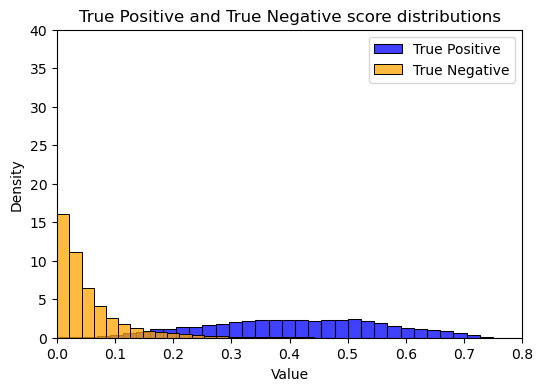

In [24]:
plot_two_distributions(tp_scores, tn_scores, label1='True Positive', label2='True Negative', bins=40, x_max=0.8, y_max=40)

Taking a closer look at the true positives

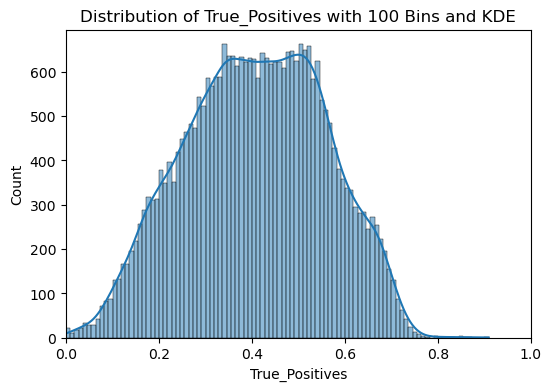

In [25]:
plot_continuous(pd.DataFrame(tp_scores, columns=['True_Positives']), 'True_Positives', x_min=0, x_max=1, bins=100)

A perfect classifier would have no overlap between these distributions.  In our case, the overlap is small. We would have virtually no false negatives with a threshold of 0.2, and a few false positives.   For now let's set a threshold of 0.2 and see what performance we get from some practical use metrics.

In [26]:
threshold = 0.2
pred_vals_binary = (pred_vals > threshold).astype(int)

In [27]:
targets = list(df_val_pred.columns)
scores_dict = classification_report(targ_vals, pred_vals_binary, target_names=targets, digits=2, output_dict=True, zero_division=1)
df_scores = pd.DataFrame.from_dict(scores_dict, orient='index')
df_scores_summary = df_scores.tail(4)
df_scores = df_scores.head(-4)
df_scores = df_scores.sort_values(by='support', ascending=False)
df_scores_summary

,precision,recall,f1-score,support
micro avg,0.331504,0.903965,0.485108,30541.0
macro avg,0.298526,0.734341,0.404626,30541.0
weighted avg,0.377935,0.903965,0.518963,30541.0
samples avg,0.431116,0.917183,0.541937,30541.0


In [28]:
len(targets)

57

In [29]:
pd.set_option('display.max_rows', 60)
df_scores.head(57)

,precision,recall,f1-score,support
Bellbird,0.472920,0.926055,0.626101,5450.0
Tomtit,0.320194,0.975650,0.482152,4271.0
Silvereye,0.239952,0.975475,0.385160,3262.0
Grey Warbler,0.322085,0.929901,0.478451,2525.0
Morepork,0.676123,0.959272,0.793185,2087.0
Chaffinch,0.427365,0.837422,0.565921,1753.0
Blackbird,0.407315,0.780707,0.535333,1669.0
Tui,0.231395,0.845540,0.363353,1379.0
New Zealand Kaka,0.284876,0.915952,0.434588,1166.0
Rifleman,0.483510,0.843782,0.614751,973.0


In [30]:
ordered_targets = list(df_scores.index)
df_val_pred_binary = pd.DataFrame(data=pred_vals_binary, columns=targets)  #columns=ordered_targets
df_val_pred_binary = df_val_pred_binary[ordered_targets]
df_val_true = df_val_true[ordered_targets]
df_val_true.head(3)

,Bellbird,Tomtit,Silvereye,Grey Warbler,Morepork,Chaffinch,Blackbird,Tui,New Zealand Kaka,Rifleman,...,Rock Wren,Mohua,Grey or Mallard Duck,Pied Stilt,New Zealand Fernbird,Australasian Harrier,Cook's Petrel,California Quail,Black Swan,Black-fronted Tern
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we are treating this as a multi-label problem it isn't possible to make a single confusion matrix summarising all samples, since some samples have mutliple values for true.  We could produce individual $2 \times 2$ confusion matrices for each class, but this isn't especially interesting for current purposes.  Instead let's remove all the multi-label rows, and treat the remainder as multi-class, single-label.

In [31]:
def build_ml_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=None,
                    cf_pth=None,
                    cf_fig_pth=None,
                    ):
    '''Make a pseudo-confusioni matrix for a multi-label classifier by filtering out any multi-label rows'''
    
    row_sums = targ_df.sum(axis=1)
    pred_df = pred_df.reindex(targ_df.index)
    targ_df = targ_df[row_sums == 1]
    pred_df = pred_df[row_sums == 1]
    
    print(f'Building a confusion from {len(targ_df)} samples with single labels')
    print(f'The number of unique classes in the input dataframes {len(set(list(targ_df.columns)))}')
    
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_idxs = np.argmax(target_arr, axis=1)
    predict_idxs = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_idxs, predict_idxs, labels=list(range(target_arr.shape[1])))
    cf_matrix_norm = confusion_matrix(target_idxs, predict_idxs, labels=list(range(target_arr.shape[1])), normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f',  cmap="crest")  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    ax_cm.set_xticks(range(len(classes)))
    ax_cm.set_xticklabels(classes, rotation=90)
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)
    return

Building a confusion from 14062 samples with single labels
The number of unique classes in the input dataframes 57


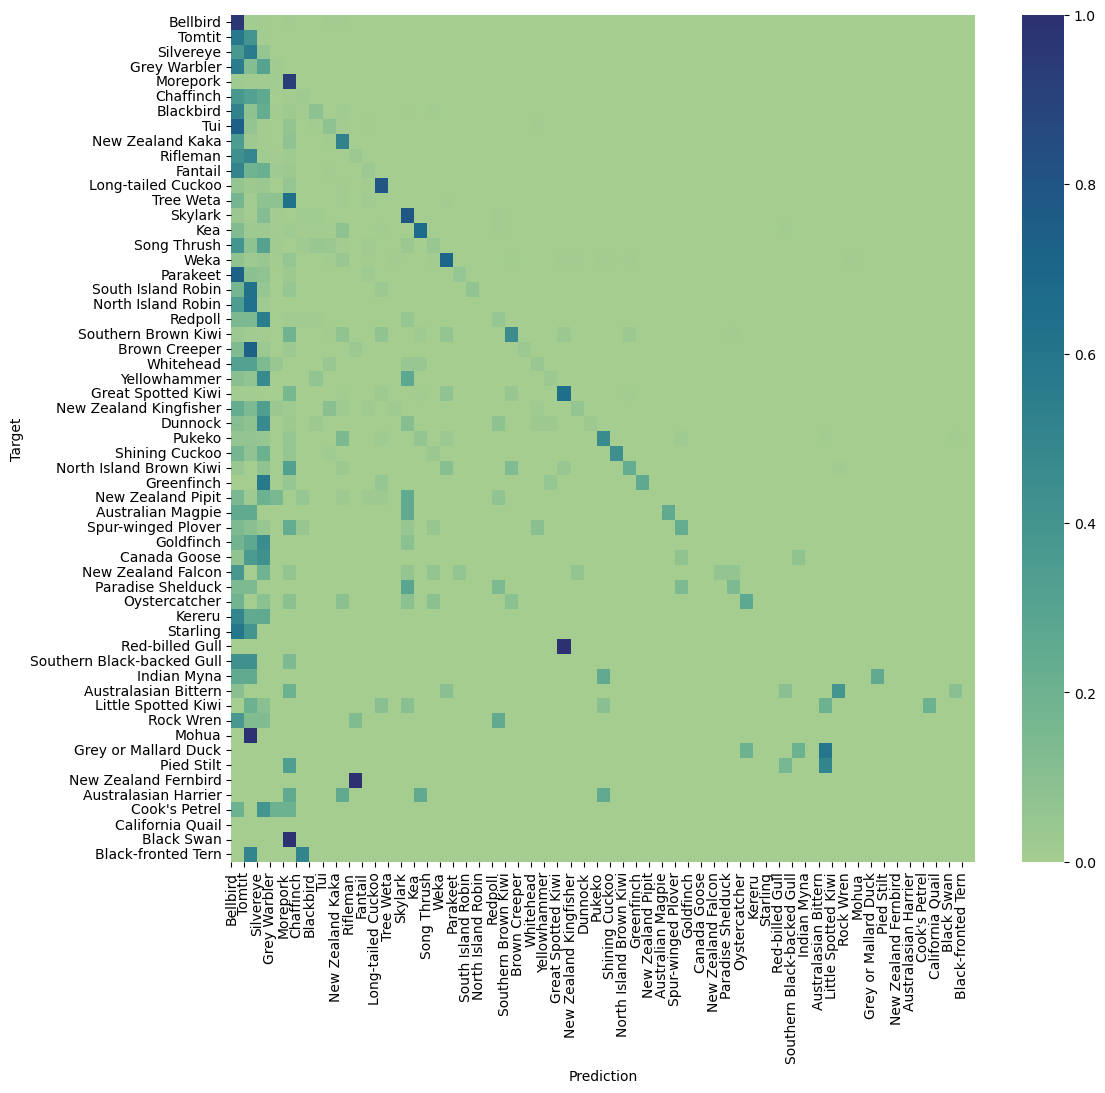

In [32]:
build_ml_cf_matrix(df_val_true, df_val_pred_binary)

This result is a bit dissappointing, though it looks explainable.  The classifier has very high recall, but poor precision. If we look specifically at the very common daytime birds, which appear in the samples of many other birds as *secondary labels* we find this to be especially true.

It does appear that not enough has been done to address the class imbalance caused by the secondary birds.

In [33]:
df_scores.loc[['Bellbird', 'Tomtit', 'Silvereye', 'Grey Warbler' ]]

,precision,recall,f1-score,support
Bellbird,0.472920,0.926055,0.626101,5450.0
Tomtit,0.320194,0.975650,0.482152,4271.0
Silvereye,0.239952,0.975475,0.385160,3262.0
Grey Warbler,0.322085,0.929901,0.478451,2525.0


## Performance with reduced classes

Merging similar sounding classses could help in a couple of ways:
- We get a more meaningful number of validation results
- Errors between those species are eliminated.  In most cases this will be of little practical consequence, as the species can be delineated by their locations.

In [34]:
df_val_pred = pd.read_pickle(paths.val_preds)
df_val_true = pd.read_pickle(paths.val_targs)
df_val_true, df_val_pred = remove_rare_classes(df_val_true, df_val_pred, 5)
eNames = list(df_val_pred.columns)
extra_names  = birdnames.extra_names(eNames)
preds_binary = (df_val_pred.values > threshold).astype(int)
df_binary = pd.DataFrame(preds_binary, columns=df_val_true.columns)
df_binary.head(3)

Removing 30 classes as they have less than 5 samples
Also removing 22 image instances, as they were from those classes


,ausbit1,ausmag2,auspip3,blfter1,blkswa,calqua,cangoo,comcha,commyn,comred,...,sonthr1,swahar1,tomtit1,tui1,weka1,weta,whiteh1,x00458,yellow2,yellow3
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
name_df = pd.DataFrame({'ebirds': eNames, 'extra_name': extra_names})
mergers = name_df.groupby('extra_name').agg({'ebirds': list})
merger_dict = mergers['ebirds'].to_dict()
print(mergers[mergers['ebirds'].apply(len) > 1])
print(Colour.S + '\nThe number of unique classes will be reduced to:' + Colour.E, f'{len(set(extra_names))}')

                                 ebirds
extra_name                             
Brown Kiwi           [nibkiw1, sobkiw2]
Cuckoo               [lotkoe1, shbcuc1]
Finch         [comcha, eurgol, eurgre1]
Gull                  [kelgul, rebgul1]
Robin                [nezrob2, nezrob3]
Spotted Kiwi         [grskiw1, liskiw1]

The number of unique classes will be reduced to: 50


In [36]:
merged_preds = {}
merged_targs = {}
for name in mergers.index.to_list():
    merging_cols = merger_dict[name]
    merging_pred_vals = df_binary[merging_cols].values
    merging_targ_vals = df_val_true[merging_cols].values
    merged_preds[name] = np.any(merging_pred_vals, axis=1).astype(int)
    merged_targs[name] = np.any(merging_targ_vals, axis=1).astype(int)

In [37]:
merged_pred_df = pd.DataFrame(merged_preds)
merged_targ_df = pd.DataFrame(merged_targs)
merged_pred_df.head()

,Bellbird,Bittern,Blackbird,Brown Kiwi,Creeper,Cuckoo,Duck,Dunnock,Falcon,Fantail,...,Tern,Thrush,Tomtit,Tui,Warbler,Weka,Weta,Whitehead,Wren,Yellowhammer
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [38]:
targets = list(merged_pred_df.columns)
scores_dict = classification_report(merged_targ_df.values, merged_pred_df.values, target_names=targets, digits=2, output_dict=True, zero_division=1)
df_merged_scores = pd.DataFrame.from_dict(scores_dict, orient='index')
df_merged_summary = df_merged_scores.tail(4)
df_merged_scores = df_merged_scores.head(-4).sort_values(by='support',  ascending=False)
df_merged_summary

,precision,recall,f1-score,support
micro avg,0.335690,0.906905,0.490005,30528.0
macro avg,0.308553,0.742160,0.417696,30528.0
weighted avg,0.379756,0.906905,0.521790,30528.0
samples avg,0.434948,0.919725,0.545891,30528.0


In [39]:
df_merged_scores

,precision,recall,f1-score,support
Bellbird,0.472920,0.926055,0.626101,5450.0
Tomtit,0.320194,0.975650,0.482152,4271.0
Silvereye,0.239952,0.975475,0.385160,3262.0
Warbler,0.322085,0.929901,0.478451,2525.0
Morepork,0.676123,0.959272,0.793185,2087.0
Finch,0.425462,0.847420,0.566502,1822.0
Blackbird,0.407315,0.780707,0.535333,1669.0
Tui,0.231395,0.845540,0.363353,1379.0
Kaka,0.284876,0.915952,0.434588,1166.0
Rifleman,0.483510,0.843782,0.614751,973.0


Looking specifically at the classes that were effected by the merger

In [40]:
merger_list = mergers[mergers['ebirds'].apply(len) > 1].index.tolist()
df_merged_scores.loc[merger_list]

,precision,recall,f1-score,support
Brown Kiwi,0.257143,0.726457,0.379836,223.0
Cuckoo,0.521465,0.954913,0.674561,865.0
Finch,0.425462,0.847420,0.566502,1822.0
Gull,0.227273,0.555556,0.322581,27.0
Robin,0.309068,0.925430,0.463380,523.0
Spotted Kiwi,0.297814,0.844961,0.440404,129.0


In [41]:
ebird_list = mergers[mergers['ebirds'].apply(len) > 1]['ebirds'].to_list()
ebird_list = [item for sublist in ebird_list for item in sublist]
common_list = birdnames.common_names(ebird_list)
df_scores.loc[common_list]

,precision,recall,f1-score,support
North Island Brown Kiwi,0.113445,0.771429,0.197802,70.0
Southern Brown Kiwi,0.385542,0.627451,0.477612,153.0
Long-tailed Cuckoo,0.503684,0.962868,0.661390,781.0
Shining Cuckoo,0.629310,0.858824,0.726368,85.0
Chaffinch,0.427365,0.837422,0.565921,1753.0
Goldfinch,0.083871,0.520000,0.144444,25.0
Greenfinch,0.126844,0.767857,0.217722,56.0
Southern Black-backed Gull,0.151515,0.384615,0.217391,13.0
Red-billed Gull,0.272727,0.642857,0.382979,14.0
North Island Robin,0.190813,0.850394,0.311688,254.0


- The mergers helped  with Brown Kiwi, Spotted Kiwi, Robin, Finch, & Cuckoo
- They did not appear not helpful for Gull, but with very small sample sizes

Perhaps this idea needs to be handled on a case by case basis, as we learn more about which birds can be realisticaly distinguished by the model and/or the humans labelling the training data.

In [42]:
merged_order = list(df_merged_scores.index)
len(merged_order)

50

Building a confusion from 14065 samples with single labels
The number of unique classes in the input dataframes 50


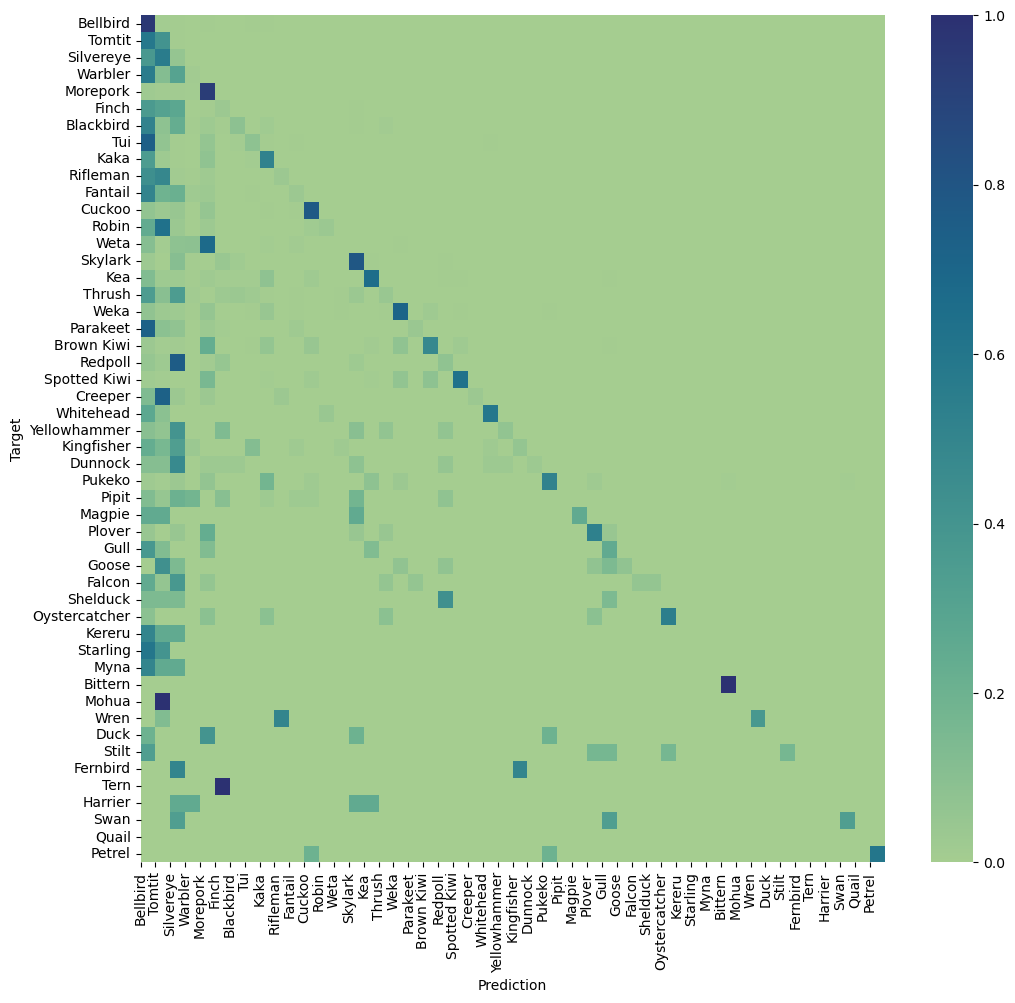

In [43]:
build_ml_cf_matrix(merged_targ_df[merged_order], merged_pred_df[merged_order])

As with earlier, the main issue here is with class embalance.  

## Prediction on soundscapes in 5 second intervals

In [44]:
print('\nThe first three recordings to be precessed are:')
for i in range(min(3, len(paths.soundscapes))):
    print(paths.soundscapes[i])


The first three recordings to be precessed are:
G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav
G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav


In [45]:
model = models.get_model(0)
prediction_dfs = []
for idx in range(len(models.args_list)):
    df = inference(paths.soundscapes, models, idx, cores=cfg.CORES)
    prediction_dfs.append(df)

Overall File List:   0%|          | 0/39 [00:00<?, ?it/s]

Average the various prediction dataframes

In [46]:
prediction_columns = prediction_dfs[0].columns[1:]
values_list = [df[prediction_columns].values for df in prediction_dfs]
average_vals = np.zeros_like(values_list[0])

for array in values_list:
    average_vals = average_vals + array 

average_vals = average_vals / len(values_list)
predictions = pd.DataFrame(data=average_vals, columns=prediction_columns)
predictions.insert(0, 'row_id', prediction_dfs[0]['row_id']) 

In [47]:
predictions.to_csv(paths.predictions_csv, index=False)

## Produce summary files:
Create a new dataframe that includes summary information for each audio file
- For each bird, first heard, last heard, total detections,
- Total length
- All birds detected (as an ordered list)
- For each bird: detections per minute

In [48]:
predictions = pd.read_csv(paths.predictions_csv)#.head(3)
predictions.columns = pd.Index(['row_id'] + common_names)
prediction_vals = (predictions.iloc[:,1:].values > threshold).astype(int)
predictions.iloc[:, 1:] = prediction_vals
predictions.head(3)

,row_id,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,AE142_BIRD_120321_085925_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AE142_BIRD_120321_085925_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AE142_BIRD_120321_085925_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
predictions.shape

(7020, 88)

In [50]:
file_map = {re.sub(r'_\d+\..*$', '', Path(fp).stem): fp for fp in paths.soundscapes}
predictions['root'] = predictions['row_id'].str.replace(r'_\d+$', '', regex=True)
predictions['filepath'] = predictions['root'].map(file_map)
predictions.drop(columns=['root'], inplace=True)
pd.set_option('display.max_colwidth', None) 
predictions.head()

,row_id,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,...,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua,filepath
0,AE142_BIRD_120321_085925_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
1,AE142_BIRD_120321_085925_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
2,AE142_BIRD_120321_085925_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
3,AE142_BIRD_120321_085925_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav
4,AE142_BIRD_120321_085925_25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav


In [51]:
def summarise(group):
    group.drop(columns=['row_id'], inplace=True)
    group = group.loc[:, (group == 1).any()]
    duration_seconds = len(group) * 5
    remaining_columns = group.columns
    column_sums = group.sum(axis=0).astype(int)
    total_birds = group.sum().sum().astype(int)
    sorted_with_values = [f'{col} ({column_sums[col]})' for col in column_sums.sort_values(ascending=False).index]
    
    all_birds = ', '.join(sorted_with_values)
    num_birds = len(remaining_columns)

    summary = pd.Series({
        'Unique_Species_Ordered': all_birds,
        'Unique_Species': num_birds,
        'Total_Detections': int(total_birds),
        'Length_(s)': duration_seconds
    })
    return summary

grouped = predictions.groupby('filepath')
summary_df = grouped.apply(summarise, include_groups=False).reset_index(drop=False)
summary_df.head(3)

,filepath,Unique_Species_Ordered,Unique_Species,Total_Detections,Length_(s)
0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav,"Bellbird (180), Tomtit (180), Silvereye (155), Rifleman (145), Tui (144), Grey Warbler (140), New Zealand Kaka (65), Parakeet (36), Chaffinch (31), Blackbird (19), Long-tailed Cuckoo (17), Kea (5), Fantail (5), Morepork (2), Brown Creeper (2), Greenfinch (2), Rock Wren (2), Dunnock (1), South Island Robin (1)",19,1132,900
1,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav,"Bellbird (168), Tomtit (159), Tui (155), New Zealand Kaka (113), Rifleman (101), Grey Warbler (100), Silvereye (86), Kea (44), Morepork (10), Chaffinch (10), Weka (10), Blackbird (9), Parakeet (8), Fantail (7), Little Spotted Kiwi (3), North Island Robin (3), Long-tailed Cuckoo (2), South Island Robin (2), Spotted Crake (2), North Island Kokako (1), Great Spotted Kiwi (1), Redpoll (1), Australian Magpie (1)",23,996,900
2,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav,"Tomtit (178), Silvereye (154), Bellbird (148), Tui (100), Grey Warbler (97), Fantail (96), Brown Creeper (69), Rifleman (46), New Zealand Kaka (31), Whitehead (24), Blackbird (20), Parakeet (19), North Island Robin (18), Chaffinch (15), Morepork (11), Redpoll (6), Long-tailed Cuckoo (5), North Island Kokako (5), Little Spotted Kiwi (2), Weka (2), Mohua (1)",21,1047,900


In [52]:
def first_detected(group):
    group.drop(columns=['row_id'], inplace=True) 
    group = group.reset_index(drop=True)
    first_non_zero = group.apply(lambda col: col.ne(0).idxmax()*5 if col.ne(0).any() else np.nan)
    return first_non_zero

grouped = predictions.groupby('filepath')
first_bird = grouped.apply(first_detected, include_groups=False).reset_index(drop=False)
columns_to_convert = first_bird.columns[1:]
first_bird[columns_to_convert] = first_bird[columns_to_convert].astype(pd.Int64Dtype())
first_bird.to_csv(paths.experiment_results / 'first_bird.csv')
first_bird.head(3)

,filepath,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav,<NA>,200,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,395,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,30,870,<NA>,<NA>,<NA>,30,<NA>,<NA>,765


In [53]:
def last_detected(group):
    group.drop(columns=['row_id'], inplace=True) 
    group = group.reset_index(drop=True)
    length = len(group) * 5
    last_non_zero = group.apply(lambda col: length - (col[::-1].ne(0).idxmax()) * 5 if col.ne(0).any() else np.nan)
    return last_non_zero

grouped = predictions.groupby('filepath')
last_bird = grouped.apply(last_detected, include_groups=False).reset_index(drop=False)
columns_to_convert = last_bird.columns[1:]
last_bird[columns_to_convert] = last_bird[columns_to_convert].astype(pd.Int64Dtype())
last_bird.to_csv(paths.experiment_results / 'last_bird.csv')
last_bird.head(3)

,filepath,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,5,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav,<NA>,700,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,5,15,85,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,5,15,25,<NA>,<NA>,<NA>,5,<NA>,<NA>,135


In [54]:
def detections_per_minute(group):
    group.drop(columns=['row_id'], inplace=True) 
    group = group.reset_index(drop=True)
    minutes = len(group) / 12
    column_sums = group.sum(axis=0).astype(int)
    bird_rate = column_sums / minutes
    bird_rates = pd.Series(bird_rate, index=group.columns).round(3).astype('float32')
    return bird_rates

grouped = predictions.groupby('filepath')
bird_rate = grouped.apply(detections_per_minute, include_groups=False).reset_index(drop=False)
bird_rate.to_csv(paths.experiment_results / 'detections_per_minute.csv')
bird_rate.head(3)

,filepath,Australasian Bittern,Australian Magpie,New Zealand Pipit,Australasian Shoveler,Marsh Crake,Black-billed Gull,Black-fronted Tern,Black Swan,Blue Whio,...,Tomtit,Tui,Weka,Welcome Swallow,Tree Weta,White-fronted Tern,Whitehead,Grey or Mallard Duck,Yellowhammer,Mohua
0,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120321_085925.wav,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.000,9.600,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRD_120322_085925.wav,0.0,0.067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.600,10.333,0.667,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,G:\Kaytoo\Data\Soundscapes\DOC_Tier1_2011\AE142_BIRM_120321_085925.wav,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.867,6.667,0.133,0.0,0.0,0.0,1.6,0.0,0.0,0.067
